# 最小值跳跃模拟（Minima Hopping Simulation）

In [1]:
import itertools
import numpy as np
from ase import Atom, Atoms
from ase.build import fcc111
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize.bfgslinesearch import BFGSLineSearch
from ase.optimize.minimahopping import MinimaHopping
from ase.io import write

In [2]:
# 设置合金参数
ELEMENT_LATTICE_CONSTANTS = {'Ag': 4.085, 'Pd': 3.890}		# 晶格常数
size = (3, 3, 4)	# 切片大小
element_choices = {'Ag': 18, 'Pd': 18}		# 分配的每种元素的原子数
permute_seed = 42		# 设定随机种子

In [3]:
def generate_slab(size, element_choices, permute_seed=None):
    if permute_seed is not None:
        np.random.seed(permute_seed)
        
    num_atoms = np.prod(size)
    atom_ordering = list(itertools.chain.from_iterable(
        [[key] * element_choices[key] for key in element_choices]))
    element_list = np.random.permutation(atom_ordering)
    
    a = np.sum([ELEMENT_LATTICE_CONSTANTS[key] * element_choices[key] / num_atoms for key in element_choices])

    slab = fcc111('Al', size=size, a=a, periodic=True, vacuum=10.0)
    slab.set_chemical_symbols(element_list)

    slab.set_calculator(EMT())

    c = FixAtoms(indices=[atom.index for atom in slab if atom.position[2] < np.mean(slab.positions[:, 2])])
    slab.set_constraint(c)
    
    dyn = BFGSLineSearch(atoms=slab, logfile=None)
    dyn.run(0.03)
    
    elements = np.array(slab.symbols)
    _, idx = np.unique(elements, return_index=True)
    elements = list(elements[np.sort(idx)])
    
    return slab, elements

In [4]:
# 生成初始晶体结构
slab, elements = generate_slab(size, element_choices, permute_seed)

# 实例化最小值跳跃 (Minima Hopping) 算法
parameters = {
    "Ediff0": 0.5,
    "T0": 200,
    "alpha1": 1.02,
    "alpha2": 1/1.02,#1/1.02=0.9804
    "beta1": 1.05,
    "beta2": 1.05,
    "beta3": 1/1.05,#1/1.05=0.9524
}

hop = MinimaHopping(atoms=slab,
                    Ediff0=parameters["Ediff0"],
                    T0=parameters["T0"],
                    alpha1=parameters["alpha1"],
                    alpha2=parameters["alpha2"],
                    beta1=parameters["beta1"],
                    beta2=parameters["beta2"],
                    beta3=parameters["beta3"])

# 运行最小值跳跃算法，总共运行2500步
hop(totalsteps=2500)
#生成2500个分子动力学文件（traj、log）和2501个优化文件，
#还生成一个名为 “minima.traj ”的文件，其中包含所有已接受的最小值。
#可以在 hop.log 文件中结合轨迹文件查看算法的进展情况。

# 保存最终的结构和信息 最终结构不一定是全局能量最小结构
#write('final_structure.traj', slab)
print('Simulation finished.')

Simulation finished.


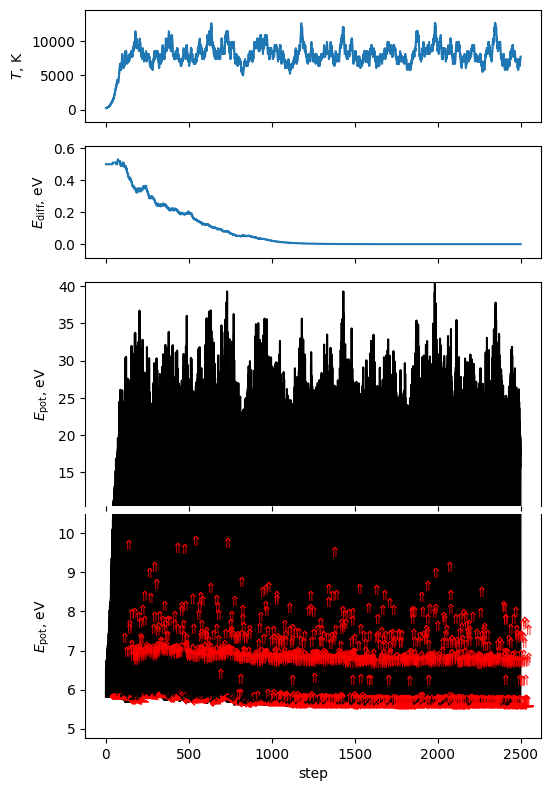

In [6]:
#一个实用程序，可以直观看到算法的进展，在与算法相同的目录下运行该工具：
from ase.optimize.minimahopping import MHPlot

mhplot = MHPlot()
mhplot.save_figure('summary.png')
#这将生成一个摘要图（summary.png文件）。
#由于搜索本身是随机的，每次重建文档时，搜索结果都会不同。
#在这张图中，Epot轴上显示的是找到的构象的能级。
#平直条代表每个局部优化步骤结束时的能量。复选标记表示局部最小值被接受；红色箭头表示由于三种可能的原因被拒绝。
#步骤之间的黑色路径是该步骤分子动力学（MD）部分的势能；虚线是 MD 步骤结束时的局部优化。
#请注意，Y 轴是断开的，以便在局部最小值和 MD 模拟中探索的空间之间有不同的能量尺度。
#T和Ediff图显示了算法进行过程中的自调整参数值。

## minima.traj文件包含所有已接受的最小值

In [64]:
# 指定要读取的 .traj 文件路径
file_path = './minima.traj'

# 使用 ASE 库加载 .traj 文件
trajectory = read(file_path, index=':')

# trajectory 是一个 Atoms 对象的列表，每个 Atoms 对象代表文件中的一帧
# 例如，打印轨迹中的每一个 Atoms 对象
#for atoms in trajectory:
#    print(atoms)

view(trajectory)

Traceback (most recent call last):
  File "/root/anaconda3/envs/catgym/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/root/anaconda3/envs/catgym/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/root/anaconda3/envs/catgym/lib/python3.8/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/root/anaconda3/envs/catgym/lib/python3.8/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/root/anaconda3/envs/catgym/lib/python3.8/site-packages/matplotlib/pyplot.py", line 353, in show
    return _backend_mod.show(*args, **kwargs)
  File "/root/anaconda3/envs/catgym/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/root/anaconda3/envs/catgym/lib/python3.8/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.


# 全局最小能量、对应步数、初始能量、相对能量和对应结构

## 从minima.traj找能量最小，再回hop.log找对应步数

In [53]:
from ase.io import read, write
import re

# 读取 minima.traj 文件的所有原子构型
all_minima = read('minima.traj', index=':')

# 初始化变量来存储最小的能量、对应的原子构型和步数
min_energy = float('inf')
min_atoms = None

# 遍历所有的原子构型
for atoms in all_minima:
    # 获取当前原子构型的能量
    energy = atoms.get_potential_energy()
    
    # 如果当前能量小于已知最小能量，则更新最小能量和对应的原子构型
    if energy < min_energy:
        min_energy = energy
        min_atoms = atoms

# 保存能量最小的原子构型到新文件
write('global_energy_minimum_structure.traj', min_atoms)

# 打印能量最低的原子构型及其能量
print(f"最小能量: {min_energy:.5f} eV")
print("对应的原子结构:")
print(min_atoms)

# 格式化 min_energy 保留五位小数
min_energy = f"{min_energy:.5f}"

# 从 hop.log 文件中查找 formatted_min_energy 和其上一行的内容
with open('hop.log', 'r') as log_file:
    log_lines = log_file.readlines()

min_step = None
initial_energy = None

for i, line in enumerate(log_lines):
    # 查找初始结构的能量
    if initial_energy is None and line.startswith("ene:"):
        parts = line.split()
        if parts[1].replace('.','',1).isdigit():  # 检查E_current是否是一个数字
            initial_energy = float(parts[1])
        
    # 查找最小能量所在位置的上一行内容
    if min_energy in line:
        if i > 0:
            previous_line = log_lines[i-1].strip()
            # 提取上一行内容中的数字
            numbers = re.findall(r'\d+', previous_line)
            if numbers:
                min_step = int(numbers[0]) + 1
                break

print(f"最小能量对应的步数: {min_step}")
print(f"初始结构的能量: {initial_energy:.5f} eV")
relative_energy = float(min_energy) - float(initial_energy)
print(f"相对能量: {relative_energy:.5f} eV")

最小能量: 5.58922 eV
对应的原子结构:
Atoms(symbols='PdAgPd2AgPd2Ag4PdAg2PdAgPdAg3PdAgPdAgPd3AgPd3AgPdAg2Pd', pbc=True, cell=[[8.458764869944076, 0.0, 0.0], [4.229382434972038, 7.3255052620109415, 0.0], [0.0, 0.0, 26.9065525951809]], momenta=..., tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), calculator=SinglePointCalculator(...))
最小能量对应的步数: 1458
初始结构的能量: 5.82274 eV
相对能量: -0.23352 eV


In [61]:
# 读取全局能量最小结构
# 指定要读取的 .traj 文件路径
file_path = './global_energy_minimum_structure.traj'

# 使用 ASE 库加载 .traj 文件
trajectory = read(file_path, index=':')

# trajectory 是一个 Atoms 对象的列表，每个 Atoms 对象代表文件中的一帧
# 例如，打印轨迹中的每一个 Atoms 对象
#for atoms in trajectory:
#    print(atoms)

view(trajectory)